In [2]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
%matplotlib inline

import cv2

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, Dropout, BatchNormalization, UpSampling2D, Concatenate
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, Callback
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.applications.vgg16 import preprocess_input

from keras_fcn import FCN

In [3]:
# Set some parameters

img_size_ori = 101
img_size_target = 224
img_chan = 3
path_train = '../data/train/'
path_test = '../data/test/'

remove_suspicious_masks = True

In [4]:
# Helper functions

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)


# Define IoU metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)


def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


def show_images(image_ids, images_folder, masks_folder=None, predictions=None, prediction_threshold=.5,
                max_images=40, grid_width=8, figsize=(20, 15),                 
                random_sample=False):
    
    grid_height = int(max_images / grid_width)
    ids = np.random.choice(image_ids, size=max_images) if random_sample else image_ids[:max_images]
    images = [np.array(load_img(images_folder + "/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(ids)]    
    masks = None
    if masks_folder is not None:
        masks = [np.array(load_img(masks_folder + "/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(ids)]    
    depths_df = pd.read_csv("../data/depths.csv", index_col="id")
    
    fig, axs = plt.subplots(grid_height, grid_width, figsize=figsize)
    
    for i, idx in enumerate(ids):
        ax = axs[int(i / grid_width), i % grid_width]
        ax.imshow(images[i], cmap="Greys")
        ax.set_title(idx)
        ax.text(1, img_size_ori-1, depths_df.loc[idx].z, color="black")
        
        if masks is not None:
            coverage = np.sum(masks[i]) / (img_size_ori * img_size_ori)
            coverage_class = np.trunc(coverage * 10).astype(int)          
            ax.imshow(masks[i], alpha=0.3, cmap="Greens")
            ax.text(img_size_ori - 1, 1, round(coverage, 2), color="black", ha="right", va="top")
            ax.text(1, 1, coverage_class, color="black", ha="left", va="top") 
        
        if predictions is not None:
            pred = predictions[i]
            ax.imshow(np.array(np.round(pred > prediction_threshold), dtype=np.float32), alpha=0.3, cmap="OrRd")       

        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")


def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(rle_mask, shape):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Data Exploration
Let's look at some data. We can see that TGS chose to use very varied data by inspecting. That is great and adresses a problem in deep learning geoscience at the moment. We build models on one type of seismic and have no idea whether it generalizes.

In [5]:
train_df = pd.read_csv("../data/train.csv", index_col="id")
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

train_df["images"] = [np.array(load_img(path_train + "images/{}.png".format(idx), color_mode = "rgb")) for idx in tqdm_notebook(train_df.index)]
test_df["images"] = [np.array(load_img(path_test + "images/{}.png".format(idx), color_mode = "rgb")) for idx in tqdm_notebook(test_df.index)]
train_df["masks"] = [np.array(load_img(path_train + "masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]

train_df["coverage"] = train_df.masks.map(np.sum) / (img_size_ori * img_size_ori)
train_df["coverage_class"] = np.trunc(train_df["coverage"] * 10)

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
train_df.fillna('', inplace=True)
train_df['suspicious'] = False

for index, row in train_df.iterrows():
    encoded_mask = row['rle_mask'].split(' ')
    if len(encoded_mask) > 1 and len(encoded_mask) < 5 and int(encoded_mask[1]) % 101 == 0:
        train_df.loc[index,'suspicious'] = True

In [7]:
if remove_suspicious_masks:
    train_df = train_df.loc[train_df.suspicious == False]

In [8]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_valid, depth_train, depth_valid = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=3456)

In [9]:
#preprocess input for vgg16
x_train = preprocess_input(x_train)
x_valid = preprocess_input(x_valid)

In [10]:
#preprocess output
y_train = np.round(y_train)
y_valid = np.round(y_valid)

In [11]:
# data augmentation 
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

# Train Model
Our task, just like the segmentation task for nuclei, is evaluated on the mean IoU metric. This one isn't in keras, but obviously, we're stealing this one too from Ketil.

This is the fun part. Building the sequential Model. The U-Net is basically looking like an Auto-Encoder with shortcuts. 

We're also sprinkling in some earlystopping to prevent overfitting. If you're running this on kaggle, this is the point, you want to have GPU support.

In [12]:
model = FCN(input_shape=(img_size_target, img_size_target, 3), classes=1,  
                      weights='imagenet', trainable_encoder=False)
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[mean_iou])

model.summary()

Loading weights...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________

In [14]:
# train the model
model_name = 'fcn-vgg16-locked'
batch_size = 16
epochs = 30

earlystopper = EarlyStopping(patience=6, verbose=1)
checkpointer = ModelCheckpoint('../models/model-tgs-salt-' + model_name + '-{epoch:02d}-{val_loss:.2f}.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
tb = TensorBoard(log_dir="../tb_logs/" + model_name, batch_size=batch_size, histogram_freq=1, write_grads=True, write_images=True)

history = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], batch_size=batch_size, epochs=epochs, 
                    callbacks=[earlystopper, checkpointer, reduce_lr, tb])

Train on 6214 samples, validate on 777 samples
Epoch 1/30


2816/6214 [============>.................] - ETA: 2:36:15 - loss: 2.4772 - mean_iou: 0.0000e+0 - ETA: 1:41:43 - loss: 3.1776 - mean_iou: 0.1261    - ETA: 1:23:30 - loss: 3.4321 - mean_iou: 0.194 - ETA: 1:14:18 - loss: 4.1514 - mean_iou: 0.233 - ETA: 1:08:47 - loss: 4.6362 - mean_iou: 0.254 - ETA: 1:05:03 - loss: 4.5102 - mean_iou: 0.267 - ETA: 1:02:23 - loss: 4.5446 - mean_iou: 0.277 - ETA: 1:00:18 - loss: 4.5767 - mean_iou: 0.285 - ETA: 58:38 - loss: 4.5939 - mean_iou: 0.2919  - ETA: 57:18 - loss: 4.4547 - mean_iou: 0.297 - ETA: 56:09 - loss: 4.5650 - mean_iou: 0.302 - ETA: 55:14 - loss: 4.5378 - mean_iou: 0.305 - ETA: 54:25 - loss: 4.6231 - mean_iou: 0.309 - ETA: 53:41 - loss: 4.5699 - mean_iou: 0.312 - ETA: 53:02 - loss: 4.4697 - mean_iou: 0.314 - ETA: 52:27 - loss: 4.4665 - mean_iou: 0.317 - ETA: 51:56 - loss: 4.3929 - mean_iou: 0.319 - ETA: 51:27 - loss: 4.3251 - mean_iou: 0.321 - ETA: 51:01 - loss: 4.3794 - mean_iou: 0.323 - ETA: 50:37 - loss: 4.2991 - mean_iou: 0.325 - ETA: 50:1

5696/6214 [==========================>...] - ETA: 26:28 - loss: 3.8789 - mean_iou: 0.371 - ETA: 26:20 - loss: 3.8632 - mean_iou: 0.371 - ETA: 26:13 - loss: 3.8599 - mean_iou: 0.371 - ETA: 26:05 - loss: 3.8736 - mean_iou: 0.371 - ETA: 25:57 - loss: 3.8745 - mean_iou: 0.371 - ETA: 25:50 - loss: 3.8677 - mean_iou: 0.371 - ETA: 25:42 - loss: 3.8652 - mean_iou: 0.371 - ETA: 25:35 - loss: 3.8652 - mean_iou: 0.371 - ETA: 25:27 - loss: 3.8707 - mean_iou: 0.371 - ETA: 25:19 - loss: 3.8674 - mean_iou: 0.371 - ETA: 25:12 - loss: 3.8672 - mean_iou: 0.371 - ETA: 25:04 - loss: 3.8568 - mean_iou: 0.371 - ETA: 24:57 - loss: 3.8469 - mean_iou: 0.371 - ETA: 24:49 - loss: 3.8536 - mean_iou: 0.371 - ETA: 24:41 - loss: 3.8626 - mean_iou: 0.372 - ETA: 24:34 - loss: 3.8724 - mean_iou: 0.372 - ETA: 24:26 - loss: 3.8657 - mean_iou: 0.372 - ETA: 24:18 - loss: 3.8703 - mean_iou: 0.372 - ETA: 24:11 - loss: 3.8679 - mean_iou: 0.372 - ETA: 24:03 - loss: 3.8594 - mean_iou: 0.372 - ETA: 23:56 - loss: 3.8516 - mean_io

6214/6214 [==============================] - ETA: 3:54 - loss: 3.8496 - mean_iou: 0.37 - ETA: 3:46 - loss: 3.8459 - mean_iou: 0.37 - ETA: 3:39 - loss: 3.8412 - mean_iou: 0.37 - ETA: 3:31 - loss: 3.8355 - mean_iou: 0.37 - ETA: 3:24 - loss: 3.8320 - mean_iou: 0.37 - ETA: 3:16 - loss: 3.8386 - mean_iou: 0.37 - ETA: 3:09 - loss: 3.8418 - mean_iou: 0.37 - ETA: 3:02 - loss: 3.8445 - mean_iou: 0.37 - ETA: 2:54 - loss: 3.8406 - mean_iou: 0.37 - ETA: 2:47 - loss: 3.8407 - mean_iou: 0.37 - ETA: 2:39 - loss: 3.8410 - mean_iou: 0.37 - ETA: 2:32 - loss: 3.8445 - mean_iou: 0.37 - ETA: 2:24 - loss: 3.8365 - mean_iou: 0.37 - ETA: 2:17 - loss: 3.8375 - mean_iou: 0.37 - ETA: 2:09 - loss: 3.8376 - mean_iou: 0.37 - ETA: 2:02 - loss: 3.8417 - mean_iou: 0.37 - ETA: 1:54 - loss: 3.8442 - mean_iou: 0.37 - ETA: 1:47 - loss: 3.8417 - mean_iou: 0.37 - ETA: 1:39 - loss: 3.8383 - mean_iou: 0.37 - ETA: 1:32 - loss: 3.8368 - mean_iou: 0.37 - ETA: 1:24 - loss: 3.8362 - mean_iou: 0.37 - ETA: 1:17 - loss: 3.8339 - mean

2848/6214 [============>.................] - ETA: 48:41 - loss: 4.2566 - mean_iou: 0.380 - ETA: 48:24 - loss: 5.2090 - mean_iou: 0.380 - ETA: 48:07 - loss: 4.4723 - mean_iou: 0.380 - ETA: 47:56 - loss: 4.0383 - mean_iou: 0.380 - ETA: 47:49 - loss: 3.7405 - mean_iou: 0.380 - ETA: 47:40 - loss: 3.9563 - mean_iou: 0.380 - ETA: 47:30 - loss: 3.8307 - mean_iou: 0.380 - ETA: 47:20 - loss: 3.9825 - mean_iou: 0.380 - ETA: 47:13 - loss: 3.9951 - mean_iou: 0.380 - ETA: 47:05 - loss: 3.9130 - mean_iou: 0.380 - ETA: 46:57 - loss: 3.9416 - mean_iou: 0.380 - ETA: 46:50 - loss: 4.0874 - mean_iou: 0.380 - ETA: 46:41 - loss: 3.9993 - mean_iou: 0.380 - ETA: 46:33 - loss: 4.0860 - mean_iou: 0.380 - ETA: 46:24 - loss: 4.1260 - mean_iou: 0.380 - ETA: 46:16 - loss: 4.0787 - mean_iou: 0.380 - ETA: 46:08 - loss: 4.0457 - mean_iou: 0.380 - ETA: 46:00 - loss: 4.1370 - mean_iou: 0.380 - ETA: 45:52 - loss: 4.2418 - mean_iou: 0.380 - ETA: 45:44 - loss: 4.3223 - mean_iou: 0.380 - ETA: 45:36 - loss: 4.2319 - mean_io

5728/6214 [==========================>...] - ETA: 25:54 - loss: 3.9292 - mean_iou: 0.380 - ETA: 25:46 - loss: 3.9174 - mean_iou: 0.380 - ETA: 25:39 - loss: 3.9184 - mean_iou: 0.380 - ETA: 25:31 - loss: 3.9208 - mean_iou: 0.380 - ETA: 25:24 - loss: 3.9114 - mean_iou: 0.380 - ETA: 25:16 - loss: 3.9013 - mean_iou: 0.380 - ETA: 25:09 - loss: 3.9019 - mean_iou: 0.380 - ETA: 25:02 - loss: 3.9025 - mean_iou: 0.380 - ETA: 24:54 - loss: 3.9143 - mean_iou: 0.380 - ETA: 24:47 - loss: 3.9131 - mean_iou: 0.380 - ETA: 24:39 - loss: 3.9059 - mean_iou: 0.380 - ETA: 24:32 - loss: 3.8954 - mean_iou: 0.380 - ETA: 24:25 - loss: 3.8876 - mean_iou: 0.380 - ETA: 24:17 - loss: 3.9039 - mean_iou: 0.380 - ETA: 24:10 - loss: 3.9108 - mean_iou: 0.380 - ETA: 24:02 - loss: 3.9022 - mean_iou: 0.380 - ETA: 23:55 - loss: 3.9134 - mean_iou: 0.380 - ETA: 23:48 - loss: 3.9120 - mean_iou: 0.380 - ETA: 23:40 - loss: 3.9069 - mean_iou: 0.380 - ETA: 23:33 - loss: 3.9072 - mean_iou: 0.380 - ETA: 23:25 - loss: 3.9123 - mean_io

6214/6214 [==============================] - ETA: 3:38 - loss: 3.8474 - mean_iou: 0.38 - ETA: 3:30 - loss: 3.8496 - mean_iou: 0.38 - ETA: 3:23 - loss: 3.8456 - mean_iou: 0.38 - ETA: 3:15 - loss: 3.8430 - mean_iou: 0.38 - ETA: 3:08 - loss: 3.8412 - mean_iou: 0.38 - ETA: 3:00 - loss: 3.8378 - mean_iou: 0.38 - ETA: 2:53 - loss: 3.8354 - mean_iou: 0.38 - ETA: 2:46 - loss: 3.8347 - mean_iou: 0.38 - ETA: 2:38 - loss: 3.8363 - mean_iou: 0.38 - ETA: 2:31 - loss: 3.8357 - mean_iou: 0.38 - ETA: 2:23 - loss: 3.8374 - mean_iou: 0.38 - ETA: 2:16 - loss: 3.8408 - mean_iou: 0.38 - ETA: 2:08 - loss: 3.8417 - mean_iou: 0.38 - ETA: 2:01 - loss: 3.8393 - mean_iou: 0.38 - ETA: 1:54 - loss: 3.8379 - mean_iou: 0.38 - ETA: 1:46 - loss: 3.8392 - mean_iou: 0.38 - ETA: 1:39 - loss: 3.8366 - mean_iou: 0.38 - ETA: 1:31 - loss: 3.8376 - mean_iou: 0.38 - ETA: 1:24 - loss: 3.8343 - mean_iou: 0.38 - ETA: 1:16 - loss: 3.8364 - mean_iou: 0.38 - ETA: 1:09 - loss: 3.8301 - mean_iou: 0.38 - ETA: 1:02 - loss: 3.8317 - mean

KeyboardInterrupt: 

NameError: name 'history' is not defined

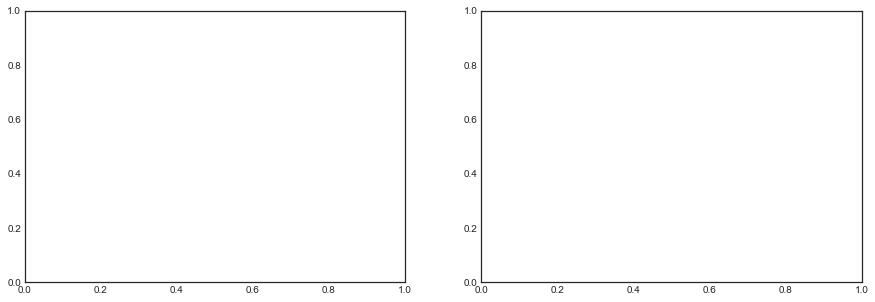

In [36]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))

ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mean_iou"], label="Train Mean_IoU")
ax_acc.plot(history.epoch, history.history["val_mean_iou"], label="Validation Mean_IoU")


In [19]:
best_model = load_model('../models/model-tgs-salt-validation-dropout-batchnorm-34-0.10.h5',
                       custom_objects={"mean_iou": mean_iou})

C:\Anaconda\envs\py35\lib\site-packages\keras\engine\saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


# Predict the validation set to do a sanity check

Again plot some sample images including the predictions.

In [53]:
preds_valid = best_model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

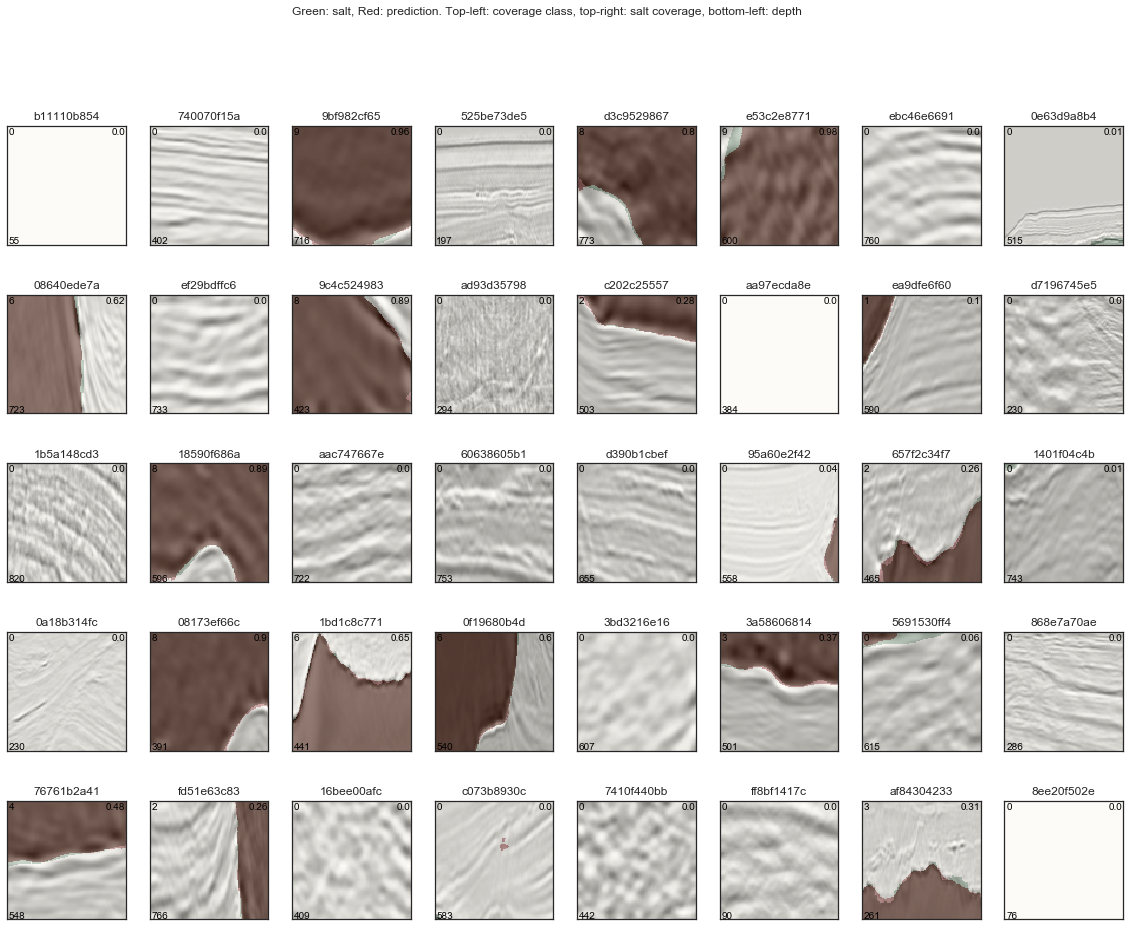

In [55]:
show_images(ids_valid, images_folder= path_train + 'images', masks_folder= path_train + 'masks',
           predictions=preds_valid)

In [56]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [57]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

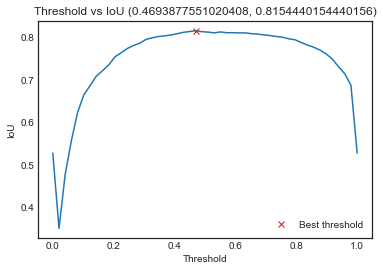

In [58]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Submission

In [25]:
x_test = np.array([upsample(np.array(load_img("../data/test/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = best_model.predict(x_test)

C:\Anaconda\envs\py35\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [26]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

# Difficult cases analysis

In [45]:
valid_df = pd.DataFrame(ids_valid, columns=["index"])
valid_df["pred"] = [np.round(pred > threshold_best) for pred in preds_valid]
valid_df["mask"] = [np.array(load_img(path_train + "masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(ids_valid)]
valid_df["coverage"] = valid_df["mask"].map(np.sum) / (101*101)
valid_df["coverage_class"] = valid_df.coverage.map(lambda x: np.trunc(x*10).astype(int))
valid_df["pred_coverage"] = valid_df["pred"].map(np.sum) / (101*101)
valid_df["pred_coverage_class"] = valid_df.pred_coverage.map(lambda x: np.trunc(x*10).astype(int))

def iou_metric_row(row):
    return iou_metric(row["mask"], row["pred"])

valid_df["iou"] = valid_df.apply(iou_metric_row, axis=1)
valid_df["outcome"] = valid_df["iou"].apply(lambda x: "good" if x > 0.8 else "average" if x > 0.2 else "bad")
valid_df = valid_df.sort_values(by="iou")

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:118: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


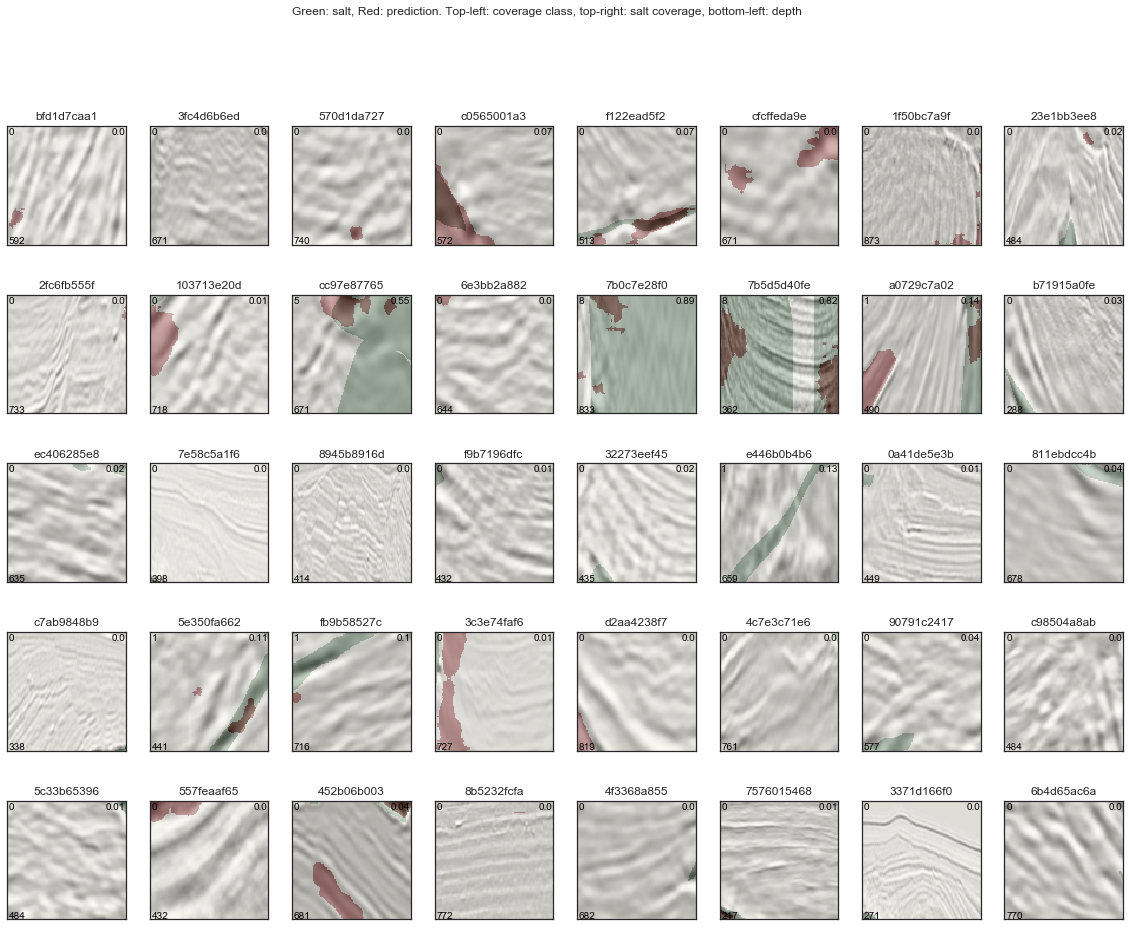

In [36]:
show_images(np.array(valid_df["index"]), images_folder= path_train + 'images', masks_folder= path_train + 'masks',
           predictions=np.array(valid_df["pred"]))

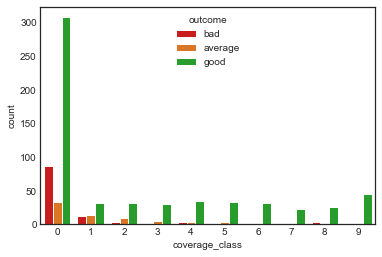

In [37]:
sns.countplot(x="coverage_class", hue="outcome", data=valid_df, palette=sns.xkcd_palette(["red", "orange", "green"]))

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:118: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


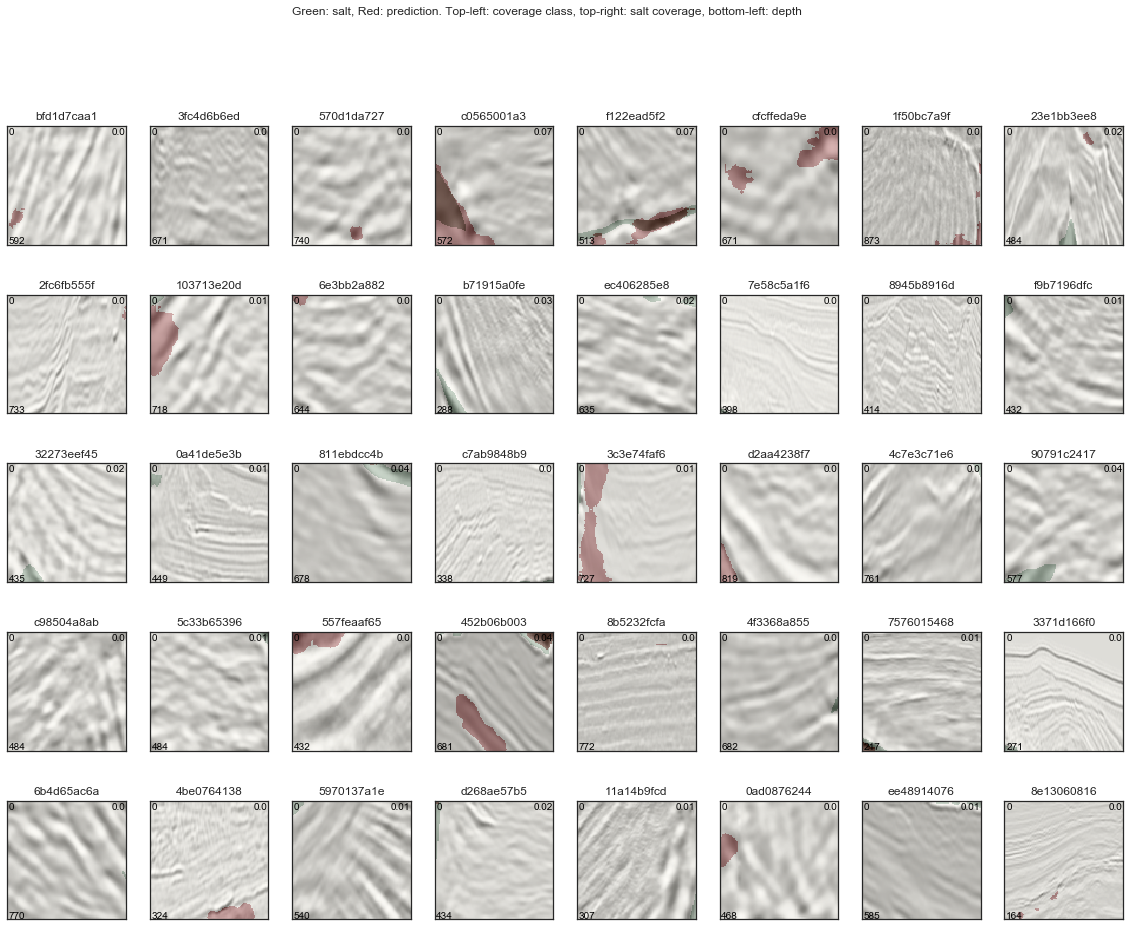

In [40]:
temp_df = valid_df[(valid_df.coverage_class == 0) & (valid_df.outcome == "bad")]

show_images(np.array(temp_df["index"]), images_folder= path_train + 'images', masks_folder= path_train + 'masks',
           predictions=np.array(temp_df["pred"]))

427


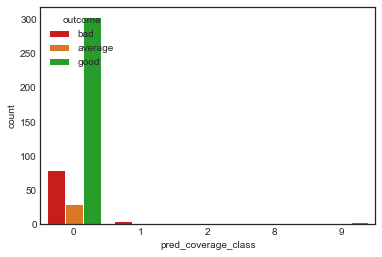

In [47]:
# where do our predictions lie for badly-predicted classes?

temp_df = valid_df[valid_df.coverage_class == 0]
print(temp_df.shape[0])
sns.countplot(x="pred_coverage_class", hue="outcome", data=temp_df, palette=sns.xkcd_palette(["red", "orange", "green"]))

In [64]:
ppred.shape

(1,)

In [73]:
iou_metric(pmask, ppred, print_table = True)

AttributeError: 'function' object has no attribute 'flatten'

In [30]:
# train a separate model just for coverage class=0 images
temp_df = train_df.loc[train_df.coverage_class == 0]


ids_train_zero, ids_valid_zero, x_train_zero, x_valid_zero, y_train_zero, y_valid_zero, cov_train_zero, cov_valid_zero, depth_train, depth_valid = train_test_split(
    temp_df.index.values,
    np.array(temp_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(temp_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    temp_df.coverage.values,
    temp_df.z.values,
    test_size=0.2, random_state=3456)

# data augmentation 
x_train_zero = np.append(x_train_zero, [np.fliplr(x) for x in x_train_zero], axis=0)
y_train_zero = np.append(y_train_zero, [np.fliplr(x) for x in y_train_zero], axis=0)

In [69]:

model_zero = UNet((img_size_target,img_size_target,1),start_ch=8,depth=5,batchnorm=True,upconv=False)
model_zero.compile(loss="binary_crossentropy", optimizer="adam", metrics=[mean_iou])

batch_size = 16
epochs = 25

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('../models/model-tgs-salt-class0-validation-dropout-batchnorm-{epoch:02d}-{val_loss:.2f}.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
tb = TensorBoard(log_dir="../tb_logs", batch_size=batch_size)

history = model_zero.fit(x_train_zero, y_train_zero, validation_data=[x_valid_zero, y_valid_zero], batch_size=batch_size, epochs=epochs, 
                    callbacks=[earlystopper, checkpointer, reduce_lr, tb])

Train on 2498 samples, validate on 313 samples
Epoch 1/25
2498/2498 [==============================] - ETA: 8:37 - loss: 0.9211 - mean_iou: 0.0000e+ - ETA: 7:09 - loss: 0.9062 - mean_iou: 0.1795   - ETA: 6:38 - loss: 0.8910 - mean_iou: 0.24 - ETA: 6:21 - loss: 0.8761 - mean_iou: 0.27 - ETA: 6:10 - loss: 0.8610 - mean_iou: 0.29 - ETA: 6:02 - loss: 0.8518 - mean_iou: 0.30 - ETA: 5:56 - loss: 0.8400 - mean_iou: 0.31 - ETA: 5:50 - loss: 0.8341 - mean_iou: 0.32 - ETA: 5:46 - loss: 0.8243 - mean_iou: 0.33 - ETA: 5:42 - loss: 0.8152 - mean_iou: 0.33 - ETA: 5:38 - loss: 0.8084 - mean_iou: 0.34 - ETA: 5:34 - loss: 0.8011 - mean_iou: 0.34 - ETA: 5:31 - loss: 0.7942 - mean_iou: 0.35 - ETA: 5:28 - loss: 0.7885 - mean_iou: 0.35 - ETA: 5:25 - loss: 0.7835 - mean_iou: 0.35 - ETA: 5:22 - loss: 0.7780 - mean_iou: 0.36 - ETA: 5:19 - loss: 0.7730 - mean_iou: 0.36 - ETA: 5:16 - loss: 0.7683 - mean_iou: 0.36 - ETA: 5:14 - loss: 0.7640 - mean_iou: 0.36 - ETA: 5:11 - loss: 0.7595 - mean_iou: 0.37 - ETA: 5:08

2498/2498 [==============================] - ETA: 5:44 - loss: 0.1385 - mean_iou: 0.49 - ETA: 5:42 - loss: 0.1382 - mean_iou: 0.49 - ETA: 5:40 - loss: 0.1378 - mean_iou: 0.49 - ETA: 5:38 - loss: 0.1377 - mean_iou: 0.49 - ETA: 5:36 - loss: 0.1373 - mean_iou: 0.49 - ETA: 5:34 - loss: 0.1369 - mean_iou: 0.49 - ETA: 5:31 - loss: 0.1366 - mean_iou: 0.49 - ETA: 5:29 - loss: 0.1362 - mean_iou: 0.49 - ETA: 5:27 - loss: 0.1358 - mean_iou: 0.49 - ETA: 5:25 - loss: 0.1354 - mean_iou: 0.49 - ETA: 5:23 - loss: 0.1350 - mean_iou: 0.49 - ETA: 5:21 - loss: 0.1346 - mean_iou: 0.49 - ETA: 5:18 - loss: 0.1342 - mean_iou: 0.49 - ETA: 5:16 - loss: 0.1338 - mean_iou: 0.49 - ETA: 5:14 - loss: 0.1334 - mean_iou: 0.49 - ETA: 5:12 - loss: 0.1330 - mean_iou: 0.49 - ETA: 5:10 - loss: 0.1326 - mean_iou: 0.49 - ETA: 5:07 - loss: 0.1323 - mean_iou: 0.49 - ETA: 5:05 - loss: 0.1319 - mean_iou: 0.49 - ETA: 5:03 - loss: 0.1315 - mean_iou: 0.49 - ETA: 5:01 - loss: 0.1311 - mean_iou: 0.49 - ETA: 4:58 - loss: 0.1308 - mean

2498/2498 [==============================] - ETA: 6:10 - loss: 0.0323 - mean_iou: 0.49 - ETA: 5:55 - loss: 0.0322 - mean_iou: 0.49 - ETA: 5:49 - loss: 0.0322 - mean_iou: 0.49 - ETA: 5:44 - loss: 0.0321 - mean_iou: 0.49 - ETA: 5:41 - loss: 0.0321 - mean_iou: 0.49 - ETA: 5:38 - loss: 0.0320 - mean_iou: 0.49 - ETA: 5:35 - loss: 0.0319 - mean_iou: 0.49 - ETA: 5:33 - loss: 0.0319 - mean_iou: 0.49 - ETA: 5:30 - loss: 0.0318 - mean_iou: 0.49 - ETA: 5:28 - loss: 0.0318 - mean_iou: 0.49 - ETA: 5:26 - loss: 0.0317 - mean_iou: 0.49 - ETA: 5:23 - loss: 0.0316 - mean_iou: 0.49 - ETA: 5:21 - loss: 0.0316 - mean_iou: 0.49 - ETA: 5:18 - loss: 0.0315 - mean_iou: 0.49 - ETA: 5:16 - loss: 0.0315 - mean_iou: 0.49 - ETA: 5:14 - loss: 0.0314 - mean_iou: 0.49 - ETA: 5:11 - loss: 0.0314 - mean_iou: 0.49 - ETA: 5:09 - loss: 0.0313 - mean_iou: 0.49 - ETA: 5:07 - loss: 0.0313 - mean_iou: 0.49 - ETA: 5:05 - loss: 0.0312 - mean_iou: 0.49 - ETA: 5:02 - loss: 0.0311 - mean_iou: 0.49 - ETA: 5:00 - loss: 0.0311 - mean

2498/2498 [==============================] - ETA: 5:47 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:44 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:42 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:40 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:37 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:35 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:33 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:30 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:28 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:26 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:24 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:21 - loss: 0.0128 - mean_iou: 0.49 - ETA: 5:19 - loss: 0.0128 - mean_iou: 0.49 - ETA: 5:17 - loss: 0.0128 - mean_iou: 0.49 - ETA: 5:15 - loss: 0.0128 - mean_iou: 0.49 - ETA: 5:12 - loss: 0.0128 - mean_iou: 0.49 - ETA: 5:10 - loss: 0.0127 - mean_iou: 0.49 - ETA: 5:08 - loss: 0.0127 - mean_iou: 0.49 - ETA: 5:06 - loss: 0.0127 - mean_iou: 0.49 - ETA: 5:04 - loss: 0.0127 - mean_iou: 0.49 - ETA: 5:01 - loss: 0.0127 - mean_iou: 0.49 - ETA: 4:59 - loss: 0.0127 - mean

2498/2498 [==============================] - ETA: 5:44 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:43 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:41 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:40 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:37 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:35 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:33 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:31 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:28 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:26 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:24 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:22 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:20 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:17 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:15 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:13 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:11 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:08 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:06 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:04 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:02 - loss: 0.0066 - mean_iou: 0.49 - ETA: 4:59 - loss: 0.0066 - mean

2498/2498 [==============================] - ETA: 5:44 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:43 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:41 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:39 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:37 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:35 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:32 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:30 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:28 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:26 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:24 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:21 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:19 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:17 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:15 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:13 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:10 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:08 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:06 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:04 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:01 - loss: 0.0040 - mean_iou: 0.49 - ETA: 4:59 - loss: 0.0040 - mean

2498/2498 [==============================] - ETA: 5:45 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:42 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:41 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:39 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:37 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:35 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:32 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:30 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:28 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:26 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:23 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:21 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:19 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:17 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:15 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:12 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:10 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:08 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:06 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:03 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:01 - loss: 0.0026 - mean_iou: 0.49 - ETA: 4:59 - loss: 0.0026 - mean

2498/2498 [==============================] - ETA: 5:44 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:43 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:41 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:39 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:37 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:35 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:33 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:30 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:28 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:26 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:24 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:22 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:19 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:17 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:15 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:13 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:10 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:08 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:06 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:04 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:01 - loss: 0.0018 - mean_iou: 0.49 - ETA: 4:59 - loss: 0.0018 - mean

KeyboardInterrupt: 

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))

ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mean_iou"], label="Train Mean_IoU")
ax_acc.plot(history.epoch, history.history["val_mean_iou"], label="Validation Mean_IoU")

In [20]:
best_zero_model = load_model('../models/model-tgs-salt-class0-validation-dropout-batchnorm-07-0.01.h5',
                       custom_objects={"mean_iou": mean_iou})

In [31]:
# threshold sweep 

preds_valid_zero = best_zero_model.predict(x_valid_zero).reshape(-1, img_size_target, img_size_target)
preds_valid_zero = np.array([downsample(x) for x in preds_valid_zero])
y_valid_zero_ori = np.array([train_df.loc[idx].masks for idx in ids_valid_zero])

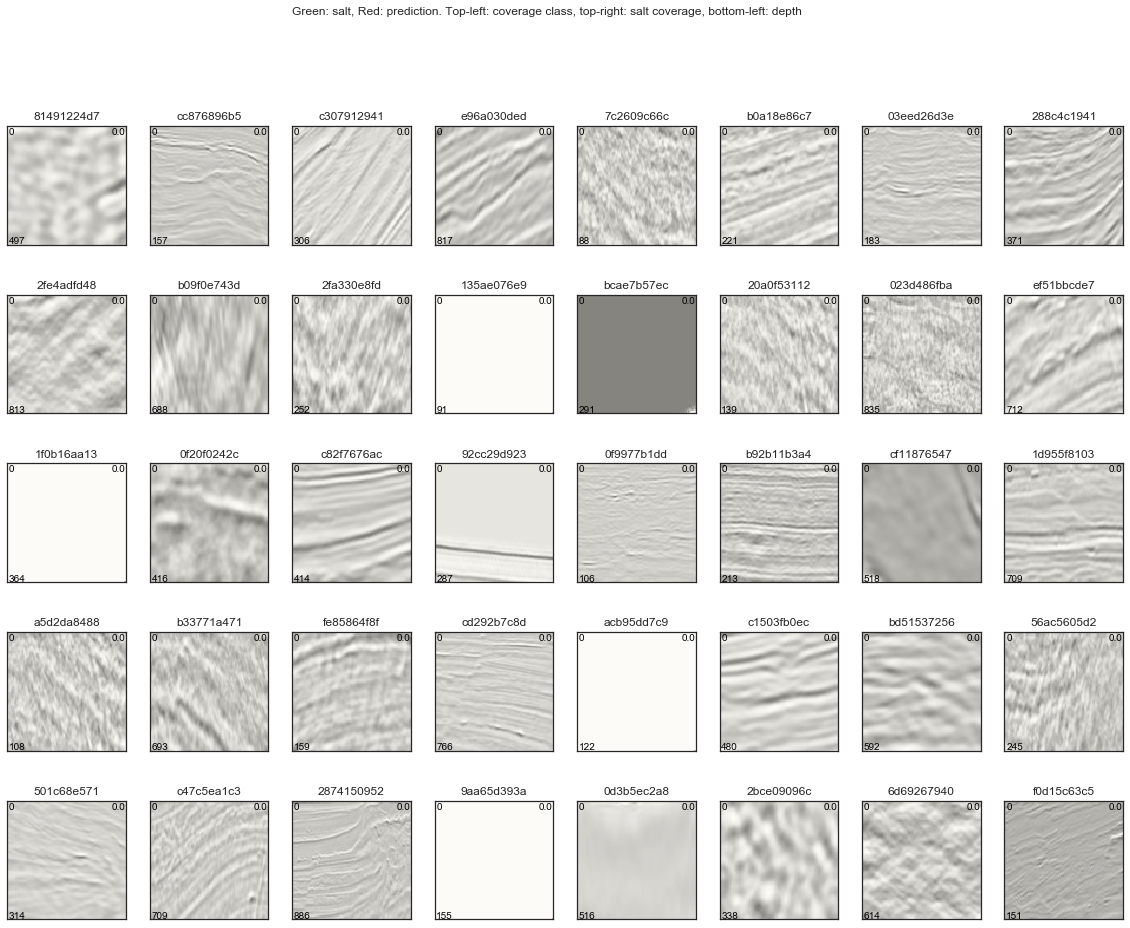

In [36]:
show_images(ids_valid_zero, images_folder= path_train + 'images', masks_folder= path_train + 'masks',
           predictions=preds_valid_zero)

In [83]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_zero_ori, np.int32(preds_valid_zero > threshold)) for threshold in tqdm_notebook(thresholds)])

In [84]:
threshold_zero_best_index = np.argmax(ious)
iou_best = ious[threshold_zero_best_index]
threshold_zero_best = thresholds[threshold_zero_best_index]

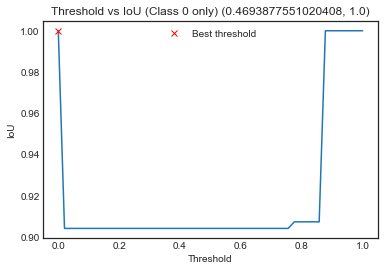

In [85]:
plt.plot(thresholds, ious)
plt.plot(threshold_zero_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU (Class 0 only) ({}, {})".format(threshold_best, iou_best))
plt.legend()

threshold_zero_best_index = 0.5

# Submission

In [63]:
x_test = np.array([upsample(np.array(load_img("../data/test/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = best_model.predict(x_test)
preds_zero_test = best_zero_model.predict(x_test)

In [64]:
preds_final = np.zeros(preds_test.shape)
for i in range(preds_test.shape[0]):
    pred_mask = np.round(preds_test[i] > threshold_best)
    pred_coverage_class = np.trunc(np.sum(pred_mask) * 10 / (128*128))
    preds_final[i] = pred_mask if pred_coverage_class > 0 else np.round(preds_zero_test[i] > 0.5)

In [65]:
preds_final.shape

(18000, 128, 128, 1)

In [66]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_final[i]))) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')